In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from RAG.retriever import QdrantRetrieverFactory
# from RAG.rag import rag
from RAG.rag import rag

In [3]:
qs = QdrantRetrieverFactory()

In [4]:
retriever = qs.retriever(collection_name="RAG_Template", fetch_k=3)
compression_retriever = qs.compression_retriever(collection_name="RAG_Template", fetch_k=10, top_n=3)

In [5]:
print(retriever.invoke("Agentic-RAG")[0].page_content)

향후 연구 및 개발 방향으로는 Agentic RAG 시스템의 자동 오류 감지 및 회복 로직 강화, 도 메인 특화 워크플로우의 최적화, 다양한 LLM 및 임베딩 모델의 정량적 성능 평가, 그리고 실시간 사용자 피드백을 반영한 동적 워크플로우 개선 등이 중요하게 제시된다. 즉, RAG와 Agentic RAG 시스템의 성능은 LLM 모델 선택, 텍스트 분할 기법, 임베딩 전략, 그리고 워크플로우의 명확한 상태 관리 및 분기 조건 설계에 의해 결 정된다. 이러한 후속 연구가 이루어진다면, RAG 및 Agentic RAG 시스템의 안정성과 효율성, 그 리고 실질적인 활용 가능성이 더욱 높아질 것으 로 기대된다.

## REFERENCES


In [6]:
chain = rag(retriever)

In [7]:
answer = chain.invoke({"question": "LangGraph 핵심 구성요소를 요약해줘", "chat_history": "[]"})

In [8]:
print(answer)

LangGraph의 핵심 구성요소는 다음과 같다:

1. **그래프 기반 상태기계(State Machine) 모델링**: 언어 모델 워크플로우를 그래프 형태로 표현하여 각 노드에서의 작업, 상태 전이, 데이터 흐름을 명확히 시각화함.
2. **노드와 엣지 조합을 통한 제어 흐름 구현**: 조건 분기, 반복 실행, 오류 처리 등을 노드와 엣지의 조합만으로 손쉽게 구현 가능.
3. **멀티에이전트 협업 구조 설계**: 복잡한 다중 에이전트 협업을 그래프 형태로 직관적으로 설계할 수 있음.
4. **오케스트레이션 및 상태 지속성, 체크포인트 기능**: 작업의 중단과 재개, 상태 저장 등을 지원하여 안정적인 워크플로우 관리 가능.

**Source**  
- docling_outputs\LangGraph-Based Integrated Architecture for CrewAI Multi-Agent.pdf.md (p.1-2)


In [9]:
# chain_rerank = rag(compression_retriever)
# chain_rerank.invoke({"question": "AgenticRAG 장점"})

# State정의

In [10]:
from typing import Annotated, TypedDict,Sequence
from langchain_core.messages import BaseMessage
from langgraph.graph import add_messages

class GraphState(TypedDict):
    question: Annotated[str, "Question"]
    context: Annotated[str, "Context"]
    answer: Annotated[str, "Answer"]
    messages: Annotated[Sequence[BaseMessage], add_messages]
    

In [11]:
from langchain_core.messages import HumanMessage, AIMessage

def get_message_history(state):
    ret = []
    for chat_message in state["messages"]:
        if chat_message.role =="user":
            ret.append(HumanMessage(content=chat_message.content))
        else:
            ret.append(AIMessage(content=chat_message.content))
            
    return ret

def retrieve_node(state):
    question = state["question"]
    retrieved_docs = retriever.invoke(question)
    
    return {"context": retrieved_docs}
from langchain_teddynote.messages import messages_to_history
def llm_answer_node(state):
    question = state["question"]
    context = state["context"]
    
    response = chain.invoke({"question": question, "context": context, "chat_history": messages_to_history(state["messages"]),})
    
    return {
        "answer": response,
        "messages": [HumanMessage(content=question), AIMessage(content=str(response))],
    }

# 그래프 생성

In [12]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver

workflow = StateGraph(GraphState)

workflow.add_node("retrieve", retrieve_node)
workflow.add_node("llm_answer", llm_answer_node)

workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "llm_answer")
workflow.add_edge("llm_answer", END)

memory = MemorySaver()

app = workflow.compile(checkpointer=memory)


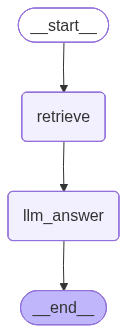

In [13]:
app

In [14]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import invoke_graph, stream_graph, random_uuid

# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=20, configurable={"thread_id": 1})

# 질문 입력
inputs = {
    "question": "AgenticAI가 좋은점은??",
}

# 그래프 실행
invoke_graph(app, inputs, config)


🔄 Node: retrieve 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
page_content='## 4.3 AI Agent에서의 경험

최근 대형 언어모델(LLM)의 발전과 더불어, 복 잡한 작업을 자동화할 수 있는 AI Agent 시스템 의 필요성이 크게 부각되고 있다. 특히, 문서 기 반 답변에서 RAG가 등장하면서, 단순한 답변 생 성에서 벗어나 문맥 파악, 동적 추론, 그리고 다 양한 도구 호출 등 복합적인 워크플로우를 스스 로 설계하고 실행할 수 있는 Agentic RAG 구조 가 주목받고 있다. 이러한 시스템은 사용자의 질 문 의도와 문맥을 파악한 뒤, 필요한 도구를 선 택해 호출하거나, 복수의 에이전트가 협력하여 문제를 해결하는 Multi-Agent System으로 확장 될 수 있다는 점에서 기존 RAG와 구별된다. 본 논문에서는 이처럼 동적인 워크플로우 설계, 문 맥 기반 의사결정, 자동 도구 활용이 가능해진 Agentic RAG 구현 경험과, 실제 운용 과정에서 얻은 실무적 인사이트를 중심으로 각 툴과 시스 템의 특징을 분석하였다.' metadata={'source': 'docling_outputs\\insight_Agentic.pdf.md', '_id': 'ddc9498a-c974-4efd-946d-836c5daf7de4', '_collection_name': 'RAG_Template'}
page_content='## Ⅱ. 배경 및 기존연구

단일 에이전트 시스템의 대표격인 AutoGPT는 ReAct(Reasoning+Acting) 패턴을 활용하여 단일 LLM이 일련의 작업을 순차적으로 수행하는 구조를 제시하였다. 이러한 방식은 복잡한 문제를 하나의 거대한 체인으로 해결한다는 점에서 혁신적이었으나, 협업이 필요한 복합 시나리오에서는 명확한 한계를 드러냈다[5]. 이어 등장한 AutoGen은 전문가 에이전 트 간의 협업과 사용자 프록시 개념을 도입하여 대 화형 코드 생성과 협력적 문제 해

In [15]:
# config 설정(재귀 최대 횟수, thread_id)
# config = RunnableConfig(recursion_limit=20, configurable={"thread_id": random_uuid()})
config = RunnableConfig(recursion_limit=20, configurable={"thread_id": 1})

# 질문 입력
inputs = {
    "question": "나의 이전 질문은?",
}

# 그래프 실행
stream_graph(app, inputs, config)


🔄 Node: llm_answer 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
사용자의 이전 질문은 "AgenticAI가 좋은점은??"입니다.

**Source**  
- 대화 내역 (CHAT HISTORY)나의 이전 질문은?사용자의 이전 질문은 "AgenticAI가 좋은점은??"입니다.

**Source**  
- 대화 내역 (CHAT HISTORY)

In [16]:
# config 설정(재귀 최대 횟수, thread_id)
# config = RunnableConfig(recursion_limit=20, configurable={"thread_id": random_uuid()})
config = RunnableConfig(recursion_limit=20, configurable={"thread_id": 1})

# 질문 입력
inputs = {
    "question": "나의 이전 질문이 뭐였지?",
}

# 그래프 실행
stream_graph(app, inputs, config)


🔄 Node: llm_answer 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
사용자의 이전 질문은 "AgenticAI가 좋은점은??"입니다.

**Source**  
- 대화 내역 (CHAT HISTORY)나의 이전 질문이 뭐였지?사용자의 이전 질문은 "AgenticAI가 좋은점은??"입니다.

**Source**  
- 대화 내역 (CHAT HISTORY)

In [17]:
config = RunnableConfig(recursion_limit=20, configurable={"thread_id": 1})
async for step in app.astream({"question": "LangGraph에서 state 확인하는 법?"}, 
                              stream_mode="updates", 
                              config=config):
    for node, value in step.items():
        print(f"\n[Node: {node}]")
        print("State:", value)


[Node: retrieve]
State: {'context': [Document(metadata={'source': 'docling_outputs\\LangGraph-Based Integrated Architecture for CrewAI Multi-Agent.pdf.md', '_id': '1dad3813-9753-44f2-a760-2945c33c4f3b', '_collection_name': 'RAG_Template'}, page_content='이에반해LangGraph는 언어 모델 워크플로우를 그 래프기반상태기계(state machine)로 모델링할 수 있 게함으로써, 각 노드에서의 작업과 상태 전이, 데이터 흐름을 명확히 시각화할 수 있는 장점을 제공한다. LangGraph를 활용하면 복잡한 멀티에이전트 협업 구 조를 그래프 형태로 직관적으로 설계할 수 있으며, 조 건분기, 반복 실행, 오류 처리 등도 노드와 엣지의 조 합만으로 손쉽게 구현할 수 있다. 실제로 LangGraph 는 오케스트레이션 및 상태 지속성, 체크포인트 기능'), Document(metadata={'source': 'docling_outputs\\insight_Agentic.pdf.md', '_id': 'babfbeef-58c0-4ac5-ad8d-15fce9d78b68', '_collection_name': 'RAG_Template'}, page_content='## 김재호(Jae-Ho Kim)\n\n수원대학교컴퓨터학부학사\n\n수원대학교컴퓨터학부석사\n\n- 수원대학교컴퓨터학부박사과정\n\nLangchain Opentutorial Core Contributor ※관심분야: 인공지능, LLM, RAG, AI Agent\n\n## 김장영(Jang-Young Kim)\n\n연세대학교컴퓨터과학공학사 Pennsylvania State Univ. 공학석사 State University of New York 공학박사 University of South Carolina 교수 수원대학교컴퓨터학부

In [18]:
value

{'answer': 'LangGraph에서 state를 확인하는 방법은, LangGraph가 언어 모델 워크플로우를 그래프 기반 상태기계(state machine)로 모델링하여 각 노드에서의 작업과 상태 전이, 데이터 흐름을 명확히 시각화하는 기능을 활용하는 것입니다. 즉, 그래프 내 각 노드와 엣지를 통해 현재 상태와 상태 전이를 직관적으로 확인할 수 있습니다. 또한, 상태 지속성 및 체크포인트 기능을 통해 상태를 관리하고 확인할 수 있습니다.\n\n**Source**  \n- docling_outputs\\LangGraph-Based Integrated Architecture for CrewAI Multi-Agent.pdf.md (2, 3)',
 'messages': [HumanMessage(content='LangGraph에서 state 확인하는 법?', additional_kwargs={}, response_metadata={}, id='9b5c45df-233f-47e8-bf11-1202ed25bc12'),
  AIMessage(content='LangGraph에서 state를 확인하는 방법은, LangGraph가 언어 모델 워크플로우를 그래프 기반 상태기계(state machine)로 모델링하여 각 노드에서의 작업과 상태 전이, 데이터 흐름을 명확히 시각화하는 기능을 활용하는 것입니다. 즉, 그래프 내 각 노드와 엣지를 통해 현재 상태와 상태 전이를 직관적으로 확인할 수 있습니다. 또한, 상태 지속성 및 체크포인트 기능을 통해 상태를 관리하고 확인할 수 있습니다.\n\n**Source**  \n- docling_outputs\\LangGraph-Based Integrated Architecture for CrewAI Multi-Agent.pdf.md (2, 3)', additional_kwargs={}, response_metadata={}, id='77370566-e28b-474a-be66-bbed6f6c3cc5')]}

In [19]:

async for step in app.astream({"question": "나의 이전 질문은??"}, 
                              stream_mode="values", 
                              config=config):
    for node, value in step.items():
        print(f"\n[Node: {node}]")
        print("State:", value)


[Node: question]
State: 나의 이전 질문은??

[Node: context]
State: [Document(metadata={'source': 'docling_outputs\\LangGraph-Based Integrated Architecture for CrewAI Multi-Agent.pdf.md', '_id': '1dad3813-9753-44f2-a760-2945c33c4f3b', '_collection_name': 'RAG_Template'}, page_content='이에반해LangGraph는 언어 모델 워크플로우를 그 래프기반상태기계(state machine)로 모델링할 수 있 게함으로써, 각 노드에서의 작업과 상태 전이, 데이터 흐름을 명확히 시각화할 수 있는 장점을 제공한다. LangGraph를 활용하면 복잡한 멀티에이전트 협업 구 조를 그래프 형태로 직관적으로 설계할 수 있으며, 조 건분기, 반복 실행, 오류 처리 등도 노드와 엣지의 조 합만으로 손쉽게 구현할 수 있다. 실제로 LangGraph 는 오케스트레이션 및 상태 지속성, 체크포인트 기능'), Document(metadata={'source': 'docling_outputs\\insight_Agentic.pdf.md', '_id': 'babfbeef-58c0-4ac5-ad8d-15fce9d78b68', '_collection_name': 'RAG_Template'}, page_content='## 김재호(Jae-Ho Kim)\n\n수원대학교컴퓨터학부학사\n\n수원대학교컴퓨터학부석사\n\n- 수원대학교컴퓨터학부박사과정\n\nLangchain Opentutorial Core Contributor ※관심분야: 인공지능, LLM, RAG, AI Agent\n\n## 김장영(Jang-Young Kim)\n\n연세대학교컴퓨터과학공학사 Pennsylvania State Univ. 공학석사 State University of New York 공학박사 University of Sout